In [ ]:
# Department: ESTSOFT
# Class: AI Modelling
# Category: Machine learning
# Title: Electricity consumption prediction
# Contributors: Jeong Gukho, Jeong Woogun, Kim Hyungeun, Kim Juneon, Kimm Soo Min
# Last modified date: 04/04/25

### **Library**

In [ ]:
# Library
# Time
from timeit import default_timer as timer
import time
from tqdm.auto import tqdm

# File
import warnings
import os
import requests
import zipfile
from pathlib import Path
from PIL import Image
import random
import chardet

# Numerical & Data Handling
import numpy as np
import pandas as pd
import scipy as sp
import math

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
from sklearn.tree import plot_tree
from scipy.optimize import curve_fit

# Machine Learning Libraries
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor, 
							  ExtraTreesClassifier, ExtraTreesRegressor, 
							  BaggingClassifier, BaggingRegressor, 
							  GradientBoostingClassifier, GradientBoostingRegressor, 
							  AdaBoostClassifier, AdaBoostRegressor, 
							  VotingClassifier, VotingRegressor,
							  StackingClassifier, StackingRegressor)
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from mlxtend.frequent_patterns import apriori, association_rules
from xgboost import XGBClassifier, XGBRegressor

# Neural Network Libraries
import torch
from torch import nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import huggingface
import keras
import tensorflow
from transformers import pipeline

# Feature Engineering
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, Normalizer, 
								   LabelEncoder, OneHotEncoder, OrdinalEncoder, LabelBinarizer)
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, RFE, SequentialFeatureSelector, VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
from mlxtend.preprocessing import TransactionEncoder
from hyperopt import hp, tpe, fmin, Trials

# Dimensionality Reduction
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# Time-Series Analysis
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Evaluation
from sklearn.metrics import (classification_report, pairwise_distances, silhouette_score, 
							 roc_curve, auc, roc_auc_score, RocCurveDisplay, 
							 confusion_matrix, ConfusionMatrixDisplay, 
							 accuracy_score, recall_score, precision_score, f1_score,
							 log_loss, hinge_loss, mean_absolute_error, mean_squared_error, r2_score)
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC, ConfusionMatrix, MeanSquaredError, MeanAbsoluteError, R2Score, MetricCollection
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor


### **Data Preparation**

**Data source**

1. 한국전력공사(KEPCO) - https://bigdata.kepco.co.kr/cmsmain.do?scode=S01&pcode=000171&redirect=Y
2. 기상청 - https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36


**Electricity consumption**
- 840 samples in total
- Jan 2015 to Dec 2024
- 7 different locations
 	- Seoul
	- Incheon
	- Daejeon 
	- Daegu
	- Ulsann
	- Gwangju
	- Busan
- 9 Features
	- Year
	- Month
	- Province
	- Number of Households
	- Avg Power Consumption per Household (kWh)
	- Avg Electricity Bill per Household (KRW)
	- Number of Tropical Nights
	- Number of Heatwave Days
	- Number of Coldwave Days

In [ ]:
# Load electricity consumption data
df_electricity = pd.read_csv('data/electricity_consumption_eng.csv', encoding='utf-8')
df_electricity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Year                                       840 non-null    int64 
 1   Month                                      840 non-null    int64 
 2   Province                                   840 non-null    object
 3   Number of Households                       840 non-null    int64 
 4   Avg Power Consumption per Household (kWh)  840 non-null    int64 
 5   Avg Electricity Btill per Household (KRW)  840 non-null    int64 
 6   Number of Tropical Nights                  840 non-null    int64 
 7   Number of Heatwave Days                    840 non-null    int64 
 8   Number of Coldwave Days                    840 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 59.2+ KB


**Weather forecast**
- 861 samples in total
- Jan 2015 to Feb 2025
- 7 different locations
 	- Seoul
	- Incheon
	- Daejeon 
	- Daegu
	- Ulsan
	- Gwangju
	- Busan
- 21 Features
	- Station Name                  
	- Year                            
	- Month                          
	- Avg Temperature (Celsius)      
	- Avg Max Temperature (Celsius) 
	- Avg Min Temperature (Celsius) 
	- Avg Local Pressure (hPa)      
	- Avg Sea Level Pressure (hPa)  
	- Avg Vapor Pressure (hPa)      
	- Avg Dew Point Temp (Celsius)  
	- Avg Relative Humidity (%)     
	- Monthly Precipitation (mm)    
	- Small Pan Evaporation (mm)    
	- Avg Wind Speed (m/s)          
	- Max Wind Speed (m/s)          
	- Avg Cloud Cover (1/10)        
	- Total Sunshine Hours (hr)     
	- Sunshine Rate (%)             
	- Total Solar Radiation (MJ/m^2)
	- Avg Min Surface Temp (Celsius)
	- Avg Ground Temp (Celsius) 

In [ ]:
# Load weather forecast data
df_weather = pd.read_csv('data/weather_forecast_eng.csv', encoding='utf-8')
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Station Name                    861 non-null    object 
 1   Year                            861 non-null    int64  
 2   Month                           861 non-null    int64  
 3   Avg Temperature (Celsius)       861 non-null    float64
 4   Avg Max Temperature (Celsius)   861 non-null    float64
 5   Avg Min Temperature (Celsius)   861 non-null    float64
 6   Avg Local Pressure (hPa)        861 non-null    float64
 7   Avg Sea Level Pressure (hPa)    861 non-null    float64
 8   Avg Vapor Pressure (hPa)        861 non-null    float64
 9   Avg Dew Point Temp (Celsius)    861 non-null    float64
 10  Avg Relative Humidity (%)       861 non-null    int64  
 11  Monthly Precipitation (mm)      861 non-null    float64
 12  Small Pan Evaporation (mm)      728 

In [50]:
# Check missing values
print(df_weather.isnull().sum())

Location                          0
Avg Temperature (Celsius)         0
Avg Max Temperature (Celsius)     0
Avg Min Temperature (Celsius)     0
Avg Local Pressure (hPa)          0
Avg Sea Level Pressure (hPa)      0
Avg Vapor Pressure (hPa)          0
Avg Dew Point Temp (Celsius)      0
Avg Relative Humidity (%)         0
Monthly Precipitation (mm)        0
Small Pan Evaporation (mm)        0
Avg Wind Speed (m/s)              0
Max Wind Speed (m/s)              0
Avg Cloud Cover (1/10)            0
Total Sunshine Hours (hr)         0
Sunshine Rate (%)                 0
Total Solar Radiation (MJ/m^2)    0
Avg Min Surface Temp (Celsius)    0
Avg Ground Temp (Celsius)         0
Date                              0
dtype: int64


In [6]:
# Handle missing values w/ ffill
df_weather.ffill(inplace=True)

In [5]:
# Re-check missing values
print(df_weather.isnull().sum())

Station Name                        0
Year                                0
Month                               0
Avg Temperature (Celsius)           0
Avg Max Temperature (Celsius)       0
Avg Min Temperature (Celsius)       0
Avg Local Pressure (hPa)            0
Avg Sea Level Pressure (hPa)        0
Avg Vapor Pressure (hPa)            0
Avg Dew Point Temp (Celsius)        0
Avg Relative Humidity (%)           0
Monthly Precipitation (mm)          0
Small Pan Evaporation (mm)        133
Avg Wind Speed (m/s)                0
Max Wind Speed (m/s)                0
Avg Cloud Cover (1/10)              6
Total Sunshine Hours (hr)           0
Sunshine Rate (%)                   0
Total Solar Radiation (MJ/m^2)     97
Avg Min Surface Temp (Celsius)      0
Avg Ground Temp (Celsius)           0
dtype: int64


In [7]:
# Create Date column using Year and Month columns
df_electricity['Date'] = pd.to_datetime(arg=dict(year=df_electricity['Year'], month=df_electricity['Month'], day=1))
df_weather['Date'] = pd.to_datetime(arg=dict(year=df_weather['Year'], month=df_weather['Month'], day=1))

# Drop Year and Month columns
df_weather = df_weather.drop(columns=['Year', 'Month'])

# Rename Station Name and Province to Location
df_electricity = df_electricity.rename(columns={'Province': 'Location'})
df_weather = df_weather.rename(columns={'Station Name': 'Location'})

# Merge df_weather and df_electricity based on Date and Location
df_merged = pd.merge(df_electricity, df_weather, on=['Date', 'Location'], how='inner') # Inner join based on Date and Location
df_merged = df_merged[['Date'] + [col for col in df_merged.columns if col != 'Date']] # Bring Date column to the front
df_merged.to_csv('data/merged_data.csv', index=False, encoding='utf-8')

### **EDA**

In [ ]:
def dual_features_plot(a: str, b: str, c: str):
	'''
	This function generates a dual-axis plot to visualize a and b averaged on c.

	Parameters:
	a (str): Column name for data in the DataFrame to compare.
	b (str): Column name for data in the DataFrame to compare.
	c (str): Column name for data in the DataFrame to set average on.

	Output:
	A dual-axis plot with bars of a and an line of b averaged on c.
	'''
	if c == 'Month':
		data = df_merged.groupby(c)[[a, b]].mean().reset_index()
	elif c == 'Year':
		data = df_merged.groupby(c)[[a, b]].sum().reset_index()
		
	fig, ax_1 = plt.subplots(figsize=(12, 8))
	ax_1.set_xlabel(f'{c}')
	ax_1.set_ylabel(f'{a}')
	ax_1.bar(data[c], data[a], color='orange')
	ax_1.tick_params(axis='y', labelcolor='orange')
	#######
	ax_2 = ax_1.twinx()
	ax_2.set_ylabel(f'{b}')
	ax_2.plot(data[c], data[b], marker='o', color='blue')
	ax_2.tick_params(axis='y', labelcolor='blue')
	for x_val,y_val in zip(data[c],data[b]):
		ax_2.text(x_val, y_val +(ax_2.get_ylim()[1] - ax_2.get_ylim()[0]) * 0.02,f'{y_val:.2f}',ha='center',va='bottom',fontsize=9,color='black')
	plt.title(f'{a} & {b} from 2015 to 2024')
	plt.grid()
	plt.tight_layout()

	plt.show()

In [ ]:
def one_feature_two_group (a: str, b: str, c: str): #a: Main Category b:Subcategory c:feature ex)서울, 감수량,가구
	"""
	Plots the mean of a single feature 'c' grouped by two categorical variables 'a' and 'b'.
	
	Parameters:
	a (str): Name of the main category column in df_merged (e.g., a higher-level group like 'Region').
	b (str): Name of the subcategory column in df_merged (e.g., a more granular group like 'City').
	c (str): Name of the feature/metric column whose mean is to be plotted (e.g., 'Sales').
	"""
	df_mean=df_merged.groupby([f'{a}',f'{b}'])[c].mean()
	plt.figure(figsize=(12, 8))
	unstacked_df = df_mean.unstack(level=f'{a}')
	unstacked_df .plot(kind='line',marker='o',ax=plt.gca())

	plt.xlabel(f'{b}')
	plt.ylabel(f'{c}')
	plt.grid()
	plt.title(f'{c} by {a} and {b}')

In [ ]:
# Heatmap
df_numeric=df_merged.select_dtypes(include=['number'])
df_corr=df_numeric.corr()
# df_corr_find = df_corr.copy()
# low_cols = df_corr_find[abs(df_corr_find['Avg Power Consumption per Household (kWh)'])<0.2].index
filter_corr=df_corr[abs(df_corr)>=0.1]
plt.figure(figsize=(20,20))
sns.heatmap(df_corr, annot=True,vmin=-1, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
#heatmap
df_numeric=df_merged.select_dtypes(include=['number'])
df_corr=df_numeric.corr()
# df_corr_find = df_corr.copy()
# low_cols = df_corr_find[abs(df_corr_find['Avg Power Consumption per Household (kWh)'])<0.2].index
df_corr=df_corr.loc[['Avg Power Consumption per Household (kWh)']]
#filter_corr=df_corr[abs(df_corr)>=0.1]
plt.figure(figsize=(20,1))
sns.heatmap(df_corr, annot=True,vmin=-1, cmap='coolwarm')
plt.title('Correlation Heatmap on Target')
plt.show()

In [ ]:
# Monthly awaitvg electricity consumption

ele_plt = df_merged.groupby('Month')['Avg Power Consumption per Household (kWh)'].mean()

plt.figure(figsize=(7, 5))
ele_plt.plot(kind='line', marker='o')
plt.title("Monthly Average Electricity Consumption from 2015 to 2024")
plt.xlabel("Month")
plt.ylabel("Avg Power Consumption per Household (kWh)")
plt.xticks(np.arange(0,13,1),rotation=0)
plt.grid()
plt.show()

In [ ]:
# Monthly average electricity consumption + temperture

avg_t_mean = df_merged.groupby('Month')['Avg Temperature (Celsius)'].mean()
avg_pc_mean = df_merged.groupby('Month')['Avg Power Consumption per Household (kWh)'].mean()

fig = plt.figure(figsize=(20,10))
fig.set_facecolor('white') 
ax = fig.add_subplot()
 
ax.bar(avg_t_mean.index, avg_t_mean , label='Avg Temperature (Celsius)')
ax.set_ylabel('Avg Temperature (Celsius)', fontsize=14, color='black') 
ax.set_xlabel('Month', fontsize=14, color='black')
 
ax2 = ax.twinx()
ax2.set_ylabel('Avg Power Consumption per Household (kWh)', fontsize=14, color='red')
ax2.plot(avg_pc_mean.index ,avg_pc_mean, label='Avg Power Consumption per Household (kWh)',color='red', linewidth = 5)

plt.xticks(np.arange(0,13,1),rotation=0)
plt.title('Avg Temperature & Avg Power Consumption per Household (kWh)',fontsize=20)
plt.legend(loc = 2, fontsize=20, frameon=True, shadow=True)

plt.show()

In [ ]:
# Monthly Avg electricity consumption boxplot

plt.figure(figsize=(10, 8))
sns.boxplot(data=df_merged, x='Month', y='Avg Power Consumption per Household (kWh)')
plt.title("Monthly Avg electricity consumption(2015~2024)")
plt.xlabel("Month")
plt.ylabel("Avg Power Consumption per Household (kWh)")
plt.show()

In [ ]:
# Monthly temperature plot
dual_features_plot(a='Avg Temperature (Celsius)', b='Monthly Precipitation (mm)', c='Month')


In [ ]:
# # #Year per: 84 Month per: 70 Location per: 140 Total data:840
# 
# monthly_data = df_merged.groupby('Location')['Avg Power Consumption per Household (kWh) Household (kWh)'].mean( ).reset_index()
# df_mean=df_merged.groupby(['YeaAvg Power Consumption per Household (kWh)r Househol# d (kWh)']).mean()
# unstacked_df = df_mean.unst# ack(level='Year')
# fig, ax_1 = plt.subplot# s(figsize=(12, 8))
# ax_1.set# _xlabel('Location')
# ax_1.set_xticks# (monthly_data.indAvg Power Consumption per Household (kWh)on # per Household (kWh)')
# ax_1.plot(monthly_data['LocAvg Power Consumption per Household (kWh)'on per Household (kWh)'], color='orange',mark# er='o', ms=4,alpha=1)

# ax_1.tick_params(axis='# y', labelcolor='orange')
# ### #####
# ax_2 = ax_Small Pan Evaporation (mm)('S# mall Pan Evaporation (mm)')
# unstacked_df.plot(k# ind='bar',ax=ax_2,alpha=0.5)
# ax_2.tick_params(# axis='y', labelcolor='blue')

# plt.title(f'Avg Power Consumption per Household#  (kWh) from#  Location,Location'# )
# plt.grid()
# plt.tight_layout()
# for x_val,y_val in zip(monthly_data['Location'],monthly_data['Avg Power C# onsumption per Household (kWh)']):
# 	ax_1.text(x_val, y_val +0.1,f'{y_val:.2f}',ha='center',va='bottom'# ,fontsize=9,color='black',zorde# r=5)
# plt.subplots_adjust(right=1.8)
# plt.show()

In [ ]:
# Number of heatwave days and avg power consumption per household by year
dual_features_plot(a='Small Pan Evaporation (mm)',b='Avg Relative Humidity (%)',c='Month')

In [ ]:
# Number of heatwave days and avg power consumption per household by year
dual_features_plot(a='Number of Heatwave Days',b='Avg Power Consumption per Household (kWh)',c='Month')


In [ ]:
bar_widths = 0.5
color_a = 'tab:red'
color_b = '#1e1690'
color_c = 'tab:orange'
col_a = 'Heatwave Days'
col_b = 'coldwave Days'
col_c = 'Tropical Nights'
data = df_merged.groupby('Month')[['Number of Heatwave Days', 'Number of Coldwave Days','Number of Tropical Nights']].mean().reset_index()
data_mean = df_merged.groupby('Month')[['Avg Power Consumption per Household (kWh)']].mean().reset_index()
fig, ax_1 = plt.subplots(figsize=(12, 8))
months = data['Month'].unique()
x = np.arange(len(months))
rects1 = ax_1.bar(data['Month'], data['Number of Heatwave Days'],label=col_a , color=color_a)
rects2 = ax_1.bar(data['Month'],  data['Number of Coldwave Days'],label=col_b, color=color_b)
rects3 = ax_1.bar(data['Month'],data['Number of Tropical Nights'],label=col_c,color=color_c,alpha=0.7)
ax_1.set_xticks(data['Month'])
ax_1.set_xlabel('Month')
ax_1.set_ylabel('Days')
ax_1.tick_params(axis='y', labelcolor='black')

#######
col_d = 'Power Consumption(kWh)'
ax_2 = ax_1.twinx()
ax_2.set_ylabel('Avg Power Consumption per Household (kWh)')
plot_c=ax_2.plot(data_mean['Month'], data_mean['Avg Power Consumption per Household (kWh)'], marker='o', color='grey',label=col_d )
ax_2.tick_params(axis='y', labelcolor='blue')
for x_val,y_val in zip(data_mean['Month'],data_mean['Avg Power Consumption per Household (kWh)']):
	ax_2.text(x_val, y_val +(ax_2.get_ylim()[1] - ax_2.get_ylim()[0]) * 0.02,f'{y_val:.2f}',ha='center',va='bottom',fontsize=10,color='black')
plt.title(f'Number of Heatwave Days & Number of Coldwave Days & Avg Power Consumption per Household (kWh) from 2015 to 2024')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.tight_layout()
handles_to_combine = [rects1, rects2,rects3] + plot_c
labels_to_combine = [h.get_label() for h in handles_to_combine]
h1,l1 =ax_1.get_legend_handles_labels()
h2,l2 =ax_2.get_legend_handles_labels()
handles = h1 + h2
labels = l1 + l2
plt.legend(handles,labels,loc='best')
plt.show()

In [ ]:
# Sunshine and avg cloud cover by month
# dual_features_plot(a='Sunshine Rate (%)', b='Avg Cloud Cover (1/10)', c='Month')
dual_features_plot(a='Avg Cloud Cover (1/10)', b='Sunshine Rate (%)', c='Month')

In [ ]:
#Monthly sunlight and evaporation
# dual_features_plot(a='Sunshine Rate (%)', b='Small Pan Evaporation (mm)', c='Month')

dual_features_plot(a='Small Pan Evaporation (mm)', b='Sunshine Rate (%)', c='Month')

In [ ]:
#Monthly Avg Wind Speed and evaporation
# dual_features_plot(a='Avg Wind Speed (m/s)', b='Small Pan Evaporation (mm)', c='Month')

dual_features_plot(a='Small Pan Evaporation (mm)', b='Avg Wind Speed (m/s)', c='Month')

In [ ]:
# Monthly ground temp plot(month)
df=df_merged.copy()
#Avg Ground Temp (Celsius)  
df_sum=df.groupby('Month')['Avg Ground Temp (Celsius)'].sum()
df_mean=df.groupby('Month')['Avg Ground Temp (Celsius)'].mean()
plt.figure(figsize=(12, 8))
df_mean.plot(kind='line',marker='o')
plt.xticks(df_mean.index)
plt.xlabel('Month')
plt.ylabel('Avg Ground Temp')
plt.title('Monthly ground temp plot')
for x_val, y_val in df_mean.items():
	plt.text(x_val+0.1,y_val+0.55,f'{y_val:.1f}',ha='center',va='bottom',fontsize=10)
plt.grid()
plt.show()

In [ ]:
one_feature_two_group('Location','Month','Number of Heatwave Days')

In [ ]:
one_feature_two_group('Location','Year','Avg Power Consumption per Household (kWh)')

In [ ]:
df_merged['Total Power Consumption (kWh)'] = df_merged['Number of Households'] * df_merged['Avg Power Consumption per Household (kWh)']
one_feature_two_group('Location','Year','Total Power Consumption (kWh)')
df_merged = df_merged.drop(columns=['Total Power Consumption (kWh)'])

In [ ]:
# Precipitation by Location

one_feature_two_group('Location','Year','Monthly Precipitation (mm)')

### **Data Preprocessing**

- Preprocessing steps safe to do before splitting
<br>

	- Remove obvious duplicates
	- Fix incorrect labels
	- Drop irrelevant columns
	- Basic data cleaning such as fixing typos or unifying units
	- Handling missing data if not based on global statistics such as dropping rows w/ missing target
	- Changing boolean type to 0 / 1
</br>

- Preprocessing steps that should happen after train-test split
<br>
	- Feature scaling / Normalisation
	- Encoding categorical variables
	- Dimensionality reduction
	- Outlier detection (if model is sensitive)
	- Feature selection based on correlation or variance
	- Creating time-based features if it involves future data
	- Data augmentation
</br>

In [8]:
# Drop columns unnecessary for training
df_merged = df_merged.drop(columns=['Date'])

In [9]:
# Data split for features and target
X = df_merged.drop(columns=['Avg Power Consumption per Household (kWh)'])
y = df_merged['Avg Power Consumption per Household (kWh)']

In [ ]:
# Grab column names of each data type
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
datetime_cols = X.select_dtypes(include=['datetime']).columns
target_col = y.name

In [ ]:
# Data split for train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Location label encoding
# label_encoder = LabelEncoder()
# for col in categorical_cols:
#     X_train[col] = label_encoder.fit_transform(X_train[col])
#     X_test[col] = label_encoder.transform(X_test[col])

# Location one hot encoding
X_train = pd.get_dummies(data=X_train, columns=['Location'], dtype=int)
X_test = pd.get_dummies(data=X_test, columns=['Location'], dtype=int)

# Scaling
scaler=StandardScaler()
X_train[numerical_cols]=scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols]=scaler.transform(X_test[numerical_cols])


In [23]:
X_train.head()

,Year,Month,Number of Households,Avg Electricity Btill per Household (KRW),Number of Tropical Nights,Number of Heatwave Days,Number of Coldwave Days,Avg Temperature (Celsius),Avg Max Temperature (Celsius),Avg Min Temperature (Celsius),...,Total Solar Radiation (MJ/m^2),Avg Min Surface Temp (Celsius),Avg Ground Temp (Celsius),Location_Busan,Location_Daegu,Location_Daejeon,Location_Gwangju,Location_Incheon,Location_Seoul,Location_Ulsan
536,-0.143756,0.703361,-0.134866,0.368167,-0.189748,-0.381374,-0.197203,0.885455,0.752934,0.968000,...,-0.433169,0.959567,0.615598,0,0,0,0,1,0,0
331,1.241246,-1.320254,-0.588454,0.718218,-0.404052,-0.381374,-0.197203,-1.318913,-1.166542,-1.403678,...,-0.696578,-1.484212,-1.248612,0,0,1,0,0,0,0
362,-1.528758,-1.031166,-0.677422,-0.181341,-0.404052,-0.381374,-0.197203,-0.704761,-0.508117,-0.853110,...,0.411185,-0.750112,-0.604787,0,0,0,1,0,0,0
468,1.587497,0.125185,-0.584242,1.283107,2.810507,0.828652,-0.197203,1.368004,1.255123,1.476217,...,0.086345,1.703326,1.269032,0,0,0,1,0,0,0
426,0.202495,0.125185,-0.619399,-0.779713,-0.404052,-0.381374,-0.197203,0.984159,0.842212,1.105642,...,-0.351978,1.326617,0.903878,0,0,0,1,0,0,0


In [ ]:
# Check multicolinearity using VIF on training data
df_vif = pd.DataFrame()
df_vif['feature'] = X_train.columns
df_vif['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
df_vif

In [ ]:
# Drop columns w/ high VIF
# X_train = X_train.drop(columns=['Avg Temperature (Celsius)', 'Avg Dew Point Temp (Celsius)', 'Avg Min Surface Temp (Celsius)'])
# X_test = X_test.drop(columns=['Avg Temperature (Celsius)', 'Avg Dew Point Temp (Celsius)', 'Avg Min Surface Temp (Celsius)'])

# # Re-check multicolinearity
# df_vif_removed = pd.DataFrame()
# df_vif_removed['feature'] = X_train.columns
# df_vif_removed['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
# df_vif_removed

In [ ]:
# PCA
pca = PCA()
pca.fit_transform(X_train)

# Find the features that contributes the most to PC 1 and PC 2 
weights_pca = abs(pca.components_)
top_pc1_idx = np.argsort(weights_pca[0])[::-1][:15]
top_pc1_name = [X_train.columns[i] for i in top_pc1_idx]

# Grab features that contribute to PC 1 and PC 2
top_features = list(set(top_pc1_name))
pca_corr = X_train[top_features].corrwith(y_train)
pca_corr

# Drop columns w/ low contributions to PC 1
X_train_pca = X_train[top_features]
X_test_pca = X_test[top_features]

### **Modelling**

Run different machine learning models w/ hyperparameter tunings. <br>
Comparison of errors using RMSE, MAE, R^2 , and adjusted R^2.
R^2 always increases when there are more features, so adjusted R^2 will penalise that impact.

In [ ]:
def adj_r2_score(y_true, y_pred, X_features):
	"""
	Compute the Adjusted R² (coefficient of determination).

	Adjusted R² adjusts the regular R² score for the number of predictors (features)
	in the model. It penalizes the R² score for adding unnecessary predictors, helping
	to avoid overfitting.

	Parameters:
	- y_true : array-like of shape (n_samples,)
		True target values.
	- y_pred : array-like of shape (n_samples,)
		Predicted target values from the model.
	- X_features : array-like of shape (n_samples, n_features)
		Data used for getting the number of predictors (features) used in the model.

	Returns:
	- adj_r2 : float
		The adjusted R-squared score. Returns NaN if the number of predictors is too large
		for the formula to be valid (i.e., n <= p + 1).
	"""
	n = len(y_true)
	p = X_features.shape[1]
	
	# Prevent division by zero or negative denominator
	if n <= p + 1:
		warnings.warn("Adjust R^2 is undefined.")
		return float('nan')
	
	return 1 - (1 - r2_score(y_true, y_pred)) * (n - 1) / (n - p - 1)

In [27]:
# Linear regression
# Training
start_time = time.time()
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
end_time = time.time()
print(f"Training time: {end_time - start_time: .4f}")

# Testing
y_pred_linear_regression = linear_regression.predict(X_test)

# Evaluation
rmse_linear_regression = math.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_linear_regression))
mae_linear_regression = mean_absolute_error(y_true=y_test, y_pred=y_pred_linear_regression)
r2_linear_regression = r2_score(y_true=y_test, y_pred=y_pred_linear_regression)
adj_r2_linear_regression = adj_r2_score(y_true=y_test, y_pred=y_pred_linear_regression)
print(f"RMSE of linear regression model: {rmse_linear_regression}")
print(f"MAE of linear regression model: {mae_linear_regression}")
print(f"R^2 of linear regression model: {r2_linear_regression}")
print(f"Adjusted R^2 of linear regression model: {adj_r2_linear_regression}")

Training time:  0.0036
RMSE of linear regression model: 15.965546658871055
MAE of linear regression model: 11.631885035279604
R^2 of linear regression model: 0.6672103938908349
Adjusted R^2 of linear regression model: 0.6058449346082938


In [ ]:
# Elastic net
# Training
hyperparams_en = {'alpha': [0.1, 1, 10],
				  'l1_ratio': [0.1, 0.5, 0.9]}
start_time = time.time()
model_en = GridSearchCV(estimator=ElasticNet(), 
								 param_grid=hyperparams_en, 
								 cv=5)
model_en.fit(X_train, y_train)
end_time = time.time()
training_time_en = end_time - start_time

# Testing
best_model_en = model_en.best_estimator_
y_pred_en = best_model_en.predict(X_test)


In [ ]:
# SVR
# Training
hyperparams_svr = {'kernel': ['poly', 'rbf', 'sigmoid'],
				   'C':[10, 100, 1000],
				   'epsilon':[0.3,0.5,0.8]}
start_time = time.time()
model_svr = GridSearchCV(estimator=SVR(),
			 			 param_grid=hyperparams_svr,
			 			 cv=5)
model_svr.fit(X_train, y_train)
end_time = time.time()
training_time_svr = end_time - start_time

# Testing
best_model_svr = model_svr.best_estimator_
y_pred_svr = best_model_svr.predict(X_test)

/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A 

In [ ]:
# Decision tree
# Training
hyperparams_dt = {'criterion': ['friedman_mse', 'absolute_error', 'squared_error', 'poisson'],
				  'max_depth': [3, 5, 7, 10, None],
				  'min_samples_split': [2, 5, 10],
				  'min_samples_leaf': [1, 2, 4],
				  'max_features': ['sqrt', 'log2', None]}
start_time=time.time()
model_dt = GridSearchCV(estimator=DecisionTreeRegressor(),
						param_grid = hyperparams_dt,
						cv=5)
model_dt.fit(X_train,y_train)
end_time = time.time()
training_time_dt = end_time - start_time

# Testing
DT_best_model = model_dt.best_estimator_
y_pred_dt = DT_best_model.predict(X_test)

Traning time : 24.0801


In [ ]:
# Random Forest
# Training
hyperparams_rf = {'n_estimators': [10, 50, 100],
				 'max_depth': [None, 10, 20],   
				 'min_samples_split': [2, 5, 10], 
				 'min_samples_leaf': [1, 2, 4],   
				 'bootstrap': [True, False],}  
start_time = time.time()
model_rf = GridSearchCV(estimator=RandomForestRegressor(),
						param_grid=hyperparams_rf,
						cv=5)
model_rf.fit(X_train,y_train)
end_time = time.time()
training_time_rf = end_time - start_time

# Testing
best_model_rf = model_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)


Training time:  229.0575


In [ ]:
# Ada
# Training
hyperparams_ada = {'n_estimators': [30,50,100],
				   'learning_rate': [0.01,0.005,0.001]}
start_time = time.time()
grid_search_ada = GridSearchCV(estimator=AdaBoostRegressor(),
							   param_grid=hyperparams_ada,
							   cv=5)
grid_search_ada.fit(X_train,y_train)
end_time = time.time()
training_time_ada = end_time - start_time

# Testing
best_model_ada = grid_search_ada.best_estimator_
y_pred_ada = best_model_ada.predict(X_test)

Training time:  7.3099


In [ ]:
# XGBRegressor
# Training
hyperparams_xgb = {'n_estimators': [100, 200, 300],
				   'learning_rate': [0.01, 0.05, 0.1],
				   'max_depth': [3, 5, 7]}
start_time = time.time()
grid_search_xgb = GridSearchCV(estimator=XGBRegressor(),
							   param_grid=hyperparams_xgb,
							   cv=5,
							   verbose=0)
grid_search_xgb.fit(X_train,y_train)
end_time = time.time()
training_time_xgb = end_time - start_time

# Testing
best_model_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_model_xgb.predict(X_test)

Training time:  57.1287


In [ ]:
# Stacking
# Training
start_time = time.time()
base_learners = [('Elastic net', best_model_en), 
				 ('SVR', best_model_svr), 
				 ('RandomForest', best_model_rf)]
meta_learner = XGBRegressor()
model_stacking = StackingRegressor(estimators=base_learners,
						   final_estimator=meta_learner,
						   cv=5)
model_stacking.fit(X_train, y_train)
end_time = time.time()
training_time_stacking = end_time - start_time

# Testing
y_pred= model_stacking.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
R2 = r2_score(y_test,y_pred)
adj_r2 = adj_r2_score(y_test,y_pred)

print(f"MSE:{mse:.4f}")
print(f"MAE:{mae:.4f}")
print(f"R2:{R2:.4f}")
print(f"adj_r2:{adj_r2:.4f}")


Training time:  3.8375
MSE:83.1652
MAE:5.7297
R2:0.8914
adj_r2:0.8714


In [ ]:
def evaluation(models: list, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series):
	for model in models:
		# Best model info
		best_model = model.best_estimator_
		best_param = model.best_params_
		model_name = str(best_model).split('(')[0]
		
		# Training
		start_time = time.time()
		model.fit(X_train, y_train)
		end_time = time.time()
		
		# Testing
		y_pred = model.predict(X_test)
		
		#
		
		

num=0
for model_info in models:
	print(num)
	model_n=model_info.best_estimator_
	para=model_info.best_params_
	model_name=str(model_n)
	model_name=model_name.split('(')[0]
	start_time = time.time()
	model_n.fit(X_train,y_train)
	end_time = time.time()
	y_pred= model_n.predict(X_test)
	mae=mean_absolute_error(y_test,y_pred)
	mse = mean_squared_error(y_test, y_pred)
	rmse = np.sqrt(mse)
	R2= r2_score(y_test,y_pred)
	adj_r2 = adj_r2_score(y_test,y_pred,X_test)
	model = pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
	model['MAE'] = mae
	model['RMSE'] = rmse
	model['R^2'] = R2
	model['adj-R^2'] =adj_r2
	model['Model'] = model_name
	model['Training_time'] = end_time - start_time
	params=[]
	for param, value in para.items():
		params.append([param, value])
	new_column_name = 'best_params'
	list_to_assign = [params] * len(model)
	model[new_column_name] = list_to_assign
	if num == 0 :
		result_model = model
		num += 1
	else:
		result_model = pd.concat([result_model, model])
		num += 1
result_model=result_model.sort_values(by=["y_test",'Model'], ascending=[True,True])
pd.options.display.float_format = '{:.2f}'.format,

models = [model_en, model_dt, model_svr, model_rf, model_ada, model_xgb, model_stacking]

0


ValueError: Found input variables with inconsistent numbers of samples: [672, 97]

In [49]:
result_model


,y_test,y_pred,MAE,RMSE,R^2,adj-R^2,Model,Training_time,best_params
346,190,219.06,10.76,14.26,0.73,0.69,AdaBoostRegressor,0.28,"[[learning_rate, 0.01], [n_estimators, 100]]"
346,190,204.00,6.18,9.16,0.89,0.87,DecisionTreeRegressor,0.09,"[[criterion, absolute_error], [max_depth, 10],..."
346,190,207.46,11.25,16.03,0.66,0.60,ElasticNet,0.01,"[[alpha, 0.1], [l1_ratio, 0.9]]"
346,190,207.14,5.26,8.17,0.91,0.90,RandomForestRegressor,0.63,"[[bootstrap, True], [max_depth, 20], [min_samp..."
346,190,193.05,5.98,8.38,0.91,0.89,SVR,0.12,"[[C, 1000], [epsilon, 0.8], [kernel, rbf]]"
...,...,...,...,...,...,...,...,...,...
835,362,329.50,6.18,9.16,0.89,0.87,DecisionTreeRegressor,0.09,"[[criterion, absolute_error], [max_depth, 10],..."
835,362,301.01,11.25,16.03,0.66,0.60,ElasticNet,0.01,"[[alpha, 0.1], [l1_ratio, 0.9]]"
835,362,323.73,5.26,8.17,0.91,0.90,RandomForestRegressor,0.63,"[[bootstrap, True], [max_depth, 20], [min_samp..."
835,362,325.39,5.98,8.38,0.91,0.89,SVR,0.12,"[[C, 1000], [epsilon, 0.8], [kernel, rbf]]"


### **Neural Network**

**Root cause of overfitting / accuracy drop**
1. Model complexity is too high for the dataset size
2. Learning rate / optimizer
3. No regularisation
4. No early stopping
5. Class imbalance
6. Feature scaling / input issues

**Ways to fix**
1. Add dropout layer
2. Switch optimizer
3. Add regularisation
4. Add early stopping
5. Check class imbalance
6. Normalise / Standardise input features

In [98]:
y_scale=StandardScaler()
y_train=y_scale.fit_transform(y_train)
y_test=y_scale.transform(y_test)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


In [ ]:

##NN start_time
import tensorflow as tf

seed=42
random.seed(seed)
np.random.seed(seed)
# random.seed(seedtf.random.set_seed(seed))
tf.random.set_seed(seed)


start_time = time.time()
# NN
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = keras.Sequential([
	keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
	keras.layers.Dense(32, activation='relu'),
	keras.layers.Dense(16, activation='relu'),
	keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=100, batch_size=64,
					validation_data=(X_valid, y_valid), verbose=1)

y_pred_NN = model.predict(X_test)
y_pred_NN = y_scale.inverse_transform(y_pred_NN).flatten()
y_test_inverse = y_scale.inverse_transform(y_test).flatten()

mae_NN = mean_absolute_error(y_true=y_test_inverse, y_pred=y_pred_NN)
rmse_NN = np.sqrt(mean_squared_error(y_true=y_test_inverse, y_pred=y_pred_NN))
r2 = r2_score(y_true=y_test_inverse, y_pred=y_pred_NN)
adj_r2_NN = adj_r2_score(y_true=y_test_inverse, y_pred=y_pred_NN, X_features=X_test)

end_time = time.time()

print(f"Training time: {end_time - start_time: .4f} \n")
print(f"R-squared (R²): {r2} \n")
print(f"adjR-squared (R²): {adj_r2_NN} \n")
print(f"mae_NN : {mae_NN} \n")
print(f"rmse_NN: {rmse_NN} \n")

Epoch 1/100


/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9211 - val_loss: 0.3784
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5585 - val_loss: 0.3199
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3794 - val_loss: 0.2071
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2658 - val_loss: 0.1836
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2043 - val_loss: 0.1484
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1723 - val_loss: 0.1277
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1512 - val_loss: 0.1097
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1326 - val_loss: 0.0963
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1186 - val_loss: 0.0891
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1076 - val_loss: 0.0871
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0977 - val_loss: 0.0863
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0894 - val_l

KeyboardInterrupt: 

In [123]:

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:

##NN 준언 수정본
y_scale=StandardScaler()
# 스케일링 전에 y_train을 2차원 배열로 변환합니다.
y_train_2d = y_train.values.reshape(-1, 1)  
y_train_scaled = y_scale.fit_transform(y_train_2d)  
# 스케일링 전에 y_test를 2차원 배열로 변환합니다.
y_test_2d = y_test.values.reshape(-1, 1)  
y_test_scaled = y_scale.transform(y_test_2d)  
# 모델에서 필요한 경우 스케일링 후 y_train_scaled와 y_test_scaled를 다시 1차원으로 변환해야 할 수 있습니다.
y_train_scaled = y_train_scaled.flatten()
y_test_scaled = y_test_scaled.flatten()

import tensorflow as tf

seed=42
random.seed(seed)
np.random.seed(seed)
# random.seed(seedtf.random.set_seed(seed))
tf.random.set_seed(seed)



start_time = time.time()
# NN
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = keras.Sequential([
	keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
	keras.layers.Dense(32, activation='relu'),
	keras.layers.Dense(16, activation='relu'),
	keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=200, batch_size=16,
					validation_data=(X_valid, y_valid), verbose=1)

y_pred_NN = model.predict(X_test)
y_pred_NN = y_scale.inverse_transform(y_pred_NN).flatten()
y_test_inverse = y_scale.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

mae_NN = mean_absolute_error(y_true=y_test_inverse, y_pred=y_pred_NN)
rmse_NN = np.sqrt(mean_squared_error(y_true=y_test_inverse, y_pred=y_pred_NN))
r2 = r2_score(y_true=y_test_inverse, y_pred=y_pred_NN)
adj_r2_NN = adj_r2_score(y_true=y_test_inverse, y_pred=y_pred_NN,X_features=X_test)

end_time = time.time()

print(f"Training time: {end_time - start_time: .4f} \n")
print(f"R-squared (R²): {r2} \n")
print(f"adjR-squared (R²): {adj_r2_NN} \n")
print(f"mae_NN : {mae_NN} \n")
print(f"rmse_NN: {rmse_NN} \n")

Epoch 1/200


/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 55568.6523 - val_loss: 50517.5430
Epoch 2/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46128.1953 - val_loss: 21617.8789
Epoch 3/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13406.3643 - val_loss: 4989.6470
Epoch 4/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4137.2173 - val_loss: 3510.7380
Epoch 5/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2699.9441 - val_loss: 2402.1626
Epoch 6/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1832.7817 - val_loss: 1668.1509
Epoch 7/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1309.3662 - val_loss: 1223.4900
Epoch 8/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 990.5529 - val_loss: 945.0893
Epoch 9/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 781.1205 - val_loss: 763.6482
Epoch 10/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 641.0792 - val_loss: 642.5725
Epoch 11/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 545.1776 - val_loss: 561.1801
Epoch 12/200

KeyboardInterrupt: 

In [ ]:
# Save evaluation data to csv
def save_evaluation_to_csv(X_train: pd.DataFrame, X_test: pd.DataFrame, data: str):
	models = {'LinearRegression': LinearRegression(),
			  'ElasticNet': elastic_net_best_model,
			  'DecisionTreeRegressor': DT_best_model,
			  'RandomForestRegressor': RF_best_model,
			  'AdaBoostRegressor': Ada_reg,
			  'XGBRegressor': xgb_reg}

	results = []
	feature_list = list(X_train.columns)

	for model_name, model in models.items():
		# Training
		start_time = time.time()
		model.fit(X_train, y_train)
		end_time = time.time()
		training_time = end_time - start_time
		
		# Testing
		y_pred = model.predict(X_test)
		
		# Evaluation
		mse = mean_squared_error(y_test, y_pred)
		rmse = math.sqrt(mean_squared_error(y_test, y_pred))
		mae = mean_absolute_error(y_test, y_pred)
		r2 = r2_score(y_test, y_pred)
		n = len(y_test)
		p = X_test.shape[1]
		adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
		
		results.append({'Model': model_name,
				  		'MSE': mse,
						'RMSE': rmse,
						'MAE': mae,
						'R2': r2,
						'Adjusted R2': adj_r2,
						'Training time': training_time,
						'Hyperparameters': str(model.get_params())})	
	
	df = pd.DataFrame(results)
	
	file = f'data/{data}_results.csv'
	header = not os.path.exists(file)	
	df.to_csv(file, mode='w', index=False, header=header)
	
	print('Evalaution reuslts saved to ', file)
	
save_evaluation_to_csv(X_train=X_train, X_test=X_test, data='original')
save_evaluation_to_csv(X_train=X_train_vif, X_test=X_test_vif, data='vif')

NameError: name 'Ada_reg' is not defined

### **Time Series Analysis**

In [80]:
# Load file
df = pd.read_csv('data/merged_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop(columns=['Year', 'Month'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
y = df['Avg Power Consumption per Household (kWh)']
y = y.resample('MS').mean()

In [81]:
# Check stationarity using Augmented Dickey-Fuller test
adf = adfuller(y.dropna())
print(f"ADF stats: {adf[0]} | p-val: {adf[1]}")

ADF stats: -0.21625904278285144 | p-val: 0.9365556288116558


In [82]:
# Split into train and test data
date = '2023-01-01'
y_train, y_test = y[:date], y[date:]

In [84]:
# SARIMAX
sarimax = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_fit = sarimax.fit()
print(sarimax_fit.summary())

                                           SARIMAX Results                                           
Dep. Variable:     Avg Power Consumption per Household (kWh)   No. Observations:                   97
Model:                        SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -339.041
Date:                                       Fri, 04 Apr 2025   AIC                            688.082
Time:                                               15:48:15   BIC                            700.236
Sample:                                           01-01-2015   HQIC                           692.968
                                                - 01-01-2023                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1944     

In [ ]:
# Prediction
y_pred = sarimax_fit.forecast(steps=len(y_test))
y_pred.index = y_test.index + pd.DateOffset(months=1)

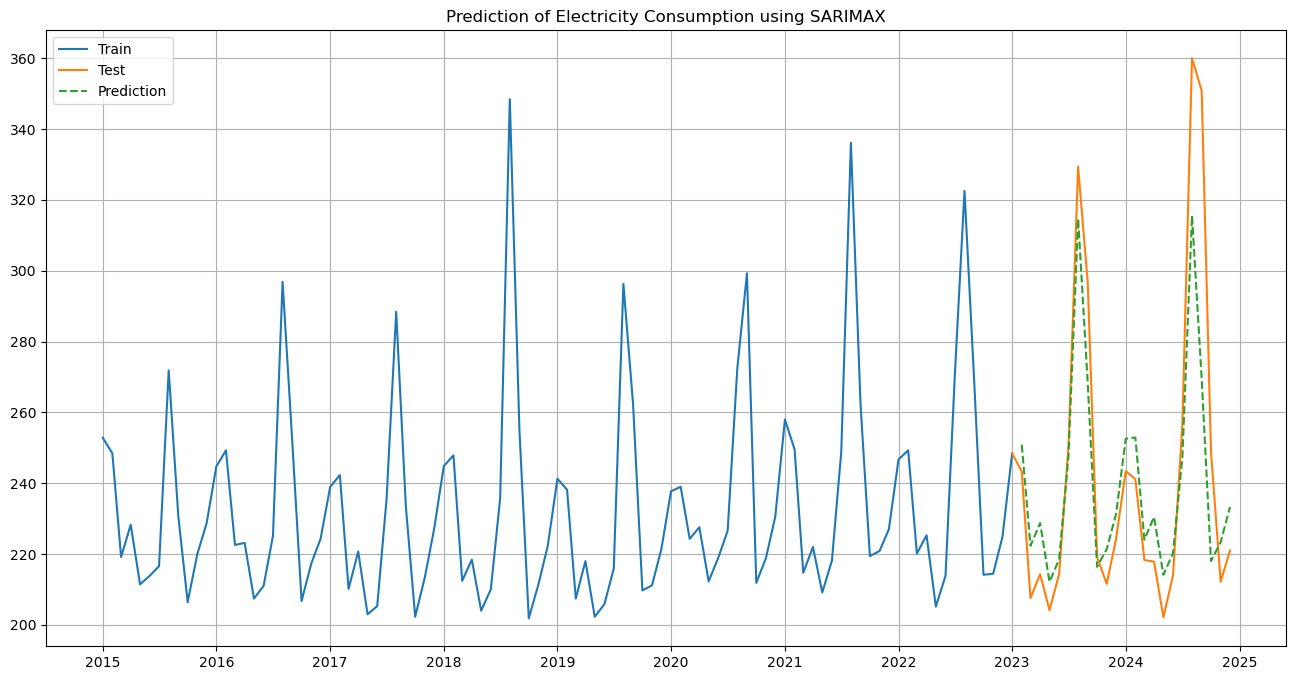

In [86]:
# Forecast
plt.figure(figsize=(16, 8))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(y_pred[:-1], label='Prediction', linestyle='--')
plt.legend()
plt.title("Prediction of Electricity Consumption using SARIMAX")
plt.grid()
plt.show()